To test the beam pattern of patched antenna

In [1]:
from spot_mission import SpotMission
from mission_environment import EnvironmentParameters
from radar_signal import Signal
from satellite import Satellite
from phased_array import PhasedArray
import numpy as np
import matplotlib.pyplot as plt
from patch_antenna import PatchAntenna
from patch_antenna_signal import PatchAntennaSignal


Patch Antenna Beam Pattern Statistics
Antenna Dimensions:
  Length: 0.02 m  (Range direction, θ)
  Width:  0.02 m   (Azimuth direction, φ)
  Ratio:  1.00:1

Gain:
  Peak Gain at Boresight: 6.77 dB
  Max Gain in Pattern:    6.77 dB
  Min Gain in Pattern:    -8.60 dB


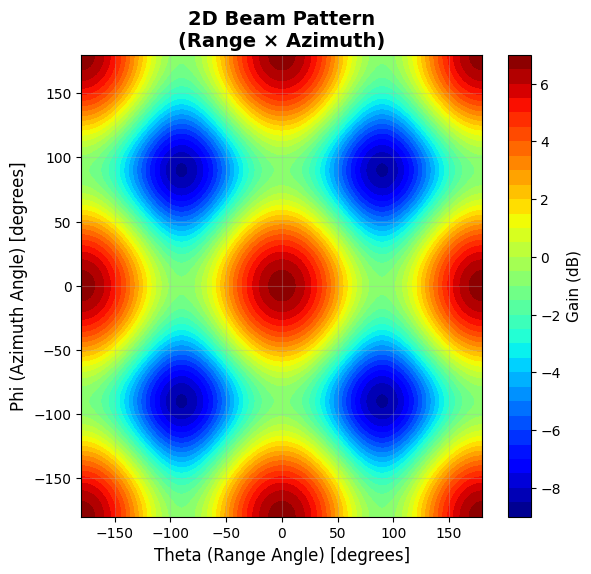

In [2]:
# Create a patch antenna and signal
patch_antenna = PatchAntenna(
    length=0.02,
    width=0.02,
    tx_power_w=3200.0,
    antenna_efficiency=0.85,
)

signal = PatchAntennaSignal(
    centre_frequency_hz=10e9,
    bandwidth_hz=1.2e9,
    prf_hz=4000.0,
    broadening_factor_azimuth=1.2,
    broadening_factor_range=1.2,
    range_processing_loss_db=0,
    azimuth_processing_loss_db=0,
    pulse_width_us=37.5,
    doppler_gain_constant=1.5,
    antenna=patch_antenna,
)

# Create theta and phi grids
theta_deg = np.linspace(-180, 180, 361*2)
phi_deg = np.linspace(-180, 180, 361*2)
theta_rad = np.deg2rad(theta_deg)
phi_rad = np.deg2rad(phi_deg)

# Create 2D meshgrid
Phi_rad, Theta_rad = np.meshgrid(theta_rad, phi_rad)

# Calculate gain pattern for each angle combination
gain_pattern = np.zeros_like(Theta_rad)
for i in range(Theta_rad.shape[0]):
    for j in range(Theta_rad.shape[1]):
        gain_pattern[i, j] = signal.gain_pattern_db(Theta_rad[i, j], Phi_rad[i, j])

# Create three subplots
fig = plt.figure(figsize=(22, 6))

# Plot 1: 2D beam pattern (phi vs theta)
ax1 = plt.subplot(131)
contour = ax1.contourf(theta_deg, phi_deg, gain_pattern, levels=30, cmap='jet')
ax1.set_xlabel('Theta (Range Angle) [degrees]', fontsize=12)
ax1.set_ylabel('Phi (Azimuth Angle) [degrees]', fontsize=12)
ax1.set_title('2D Beam Pattern\n(Range × Azimuth)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
cbar1 = fig.colorbar(contour, ax=ax1)
cbar1.set_label('Gain (dB)', fontsize=11)

# Print statistics
print(f"\n{'='*60}")
print(f"Patch Antenna Beam Pattern Statistics")
print(f"{'='*60}")
print(f"Antenna Dimensions:")
print(f"  Length: {patch_antenna.length} m  (Range direction, θ)")
print(f"  Width:  {patch_antenna.width} m   (Azimuth direction, φ)")
print(f"  Ratio:  {patch_antenna.length/patch_antenna.width:.2f}:1")
print(f"\nGain:")
print(f"  Peak Gain at Boresight: {signal.peak_antenna_gain_db:.2f} dB")
print(f"  Max Gain in Pattern:    {np.nanmax(gain_pattern):.2f} dB")
print(f"  Min Gain in Pattern:    {np.nanmin(gain_pattern):.2f} dB")
print(f"{'='*60}")

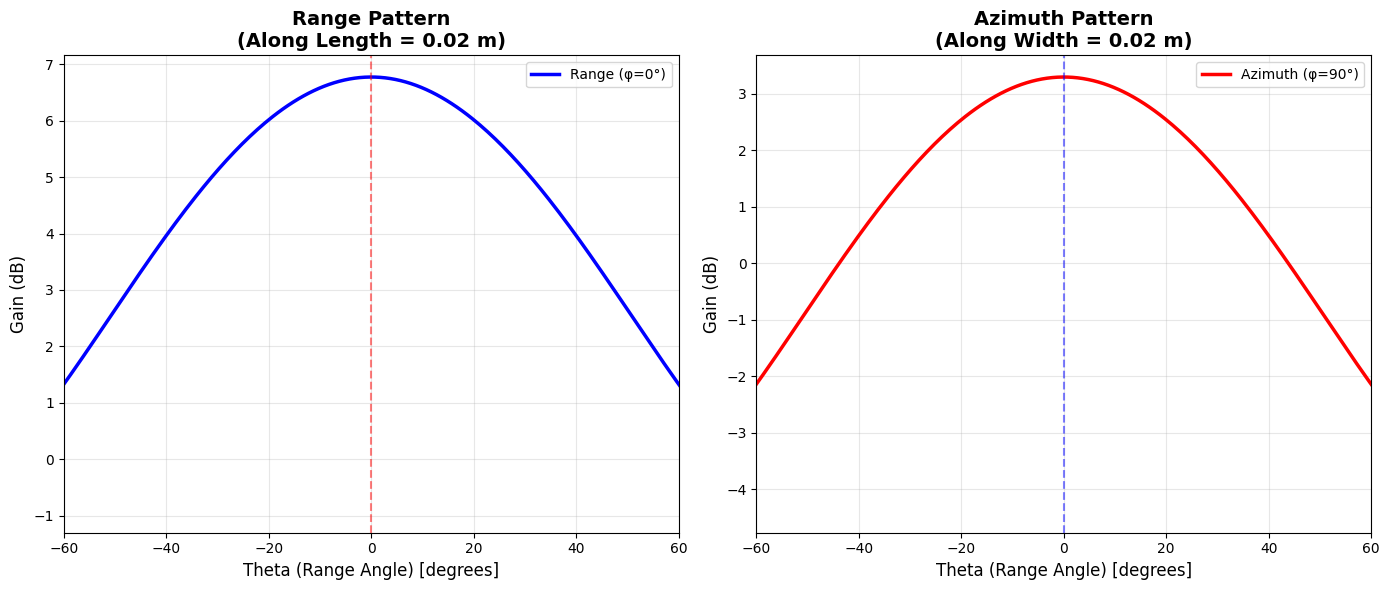


Antenna Dimensions:
  Length: 0.02 m
  Width:  0.02 m
  Ratio:  1.00:1


In [3]:
# Compare beam patterns along Length vs Width directions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get indices
phi_0_idx = len(phi_deg) // 2  # phi=0
theta_0_idx = len(theta_deg) // 2  # theta=0

# Plot 1: Range pattern (along length, phi=0)
ax1 = axes[0]
gain_e_plane = gain_pattern[phi_0_idx, :]
ax1.plot(theta_deg, gain_e_plane, 'b-', linewidth=2.5, label='Range (φ=0°)')
ax1.set_xlabel('Theta (Range Angle) [degrees]', fontsize=12)
ax1.set_ylabel('Gain (dB)', fontsize=12)
ax1.set_title(f'Range Pattern\n(Along Length = {patch_antenna.length} m)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax1.legend()
ax1.set_xlim([-60, 60])

# Plot 2: Azimuth pattern (along width, phi=90)
ax2 = axes[1]
phi_90_idx = phi_0_idx + 90  # phi=90 degrees
if phi_90_idx < len(phi_deg):
    gain_h_plane = gain_pattern[phi_90_idx, :]
    ax2.plot(theta_deg, gain_h_plane, 'r-', linewidth=2.5, label='Azimuth (φ=90°)')
ax2.set_xlabel('Theta (Range Angle) [degrees]', fontsize=12)
ax2.set_ylabel('Gain (dB)', fontsize=12)
ax2.set_title(f'Azimuth Pattern\n(Along Width = {patch_antenna.width} m)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='b', linestyle='--', alpha=0.5)
ax2.legend()
ax2.set_xlim([-60, 60])

plt.tight_layout()
plt.show()

print(f"\nAntenna Dimensions:")
print(f"  Length: {patch_antenna.length} m")
print(f"  Width:  {patch_antenna.width} m")
print(f"  Ratio:  {patch_antenna.length/patch_antenna.width:.2f}:1")

## Validation of Radiation Pattern Equations

For a **rectangular aperture antenna** (patch antenna), the normalized radiation pattern is:

### Theory:
For a uniform aperture of dimension $D$, the far-field pattern is:

$$F(\psi) = \text{sinc}\left(\frac{u}{\pi}\right) = \frac{\sin(u)}{u}$$

where the argument is:

$$u = \frac{k \cdot D}{2} \cdot \sin(\psi) = \frac{\pi \cdot D}{\lambda} \cdot \sin(\psi)$$

with:
- $k = \frac{2\pi}{\lambda}$ (wavenumber)
- $D$ = aperture dimension (m)
- $\lambda$ = wavelength (m)
- $\psi$ = angle from boresight (radians)

### Separable 3D Pattern:
For a rectangular aperture with dimensions $L \times W$:

$$F(\theta, \phi) = F_{\text{elevation}}(\theta) \times F_{\text{azimuth}}(\phi)$$

where:

$$F_{\text{elevation}}(\theta) = \text{sinc}\left(\frac{\pi L}{\lambda} \sin\theta\right)$$

$$F_{\text{azimuth}}(\phi) = \text{sinc}\left(\frac{\pi W}{\lambda} \sin\phi\right)$$

### Implementation:
```python
k = 2 * π/λ
u_elevation = (k * L / 2) * sin(θ) = (π * L / λ) * sin(θ)
u_azimuth = (k * W / 2) * sin(φ) = (π * W / λ) * sin(φ)

F_elevation = sinc(u_elevation / π)
F_azimuth = sinc(u_azimuth / π)
F_total = F_elevation × F_azimuth
```

**Note:** `np.sinc(x) = sin(πx)/(πx)`, so to compute `sin(u)/u`, we use `np.sinc(u/π)`

# NESZ Map Across Swath
Now let's create a mission and plot the NESZ variation across the entire swath

In [26]:
# Create a SpotMission instance with patch antenna
# Satellite configuration (matching reference)
satellite = Satellite(
    orbit_altitude_m=500_000.0,       # Fixed for mission
    look_angle_from_nadir_deg=35.0,    # Side-looking angle (typical SAR: 20-45°)
    platform_velocity_mps=7000.0,     # Fixed for a LEO satellite
    receiver_noise_factor_db=4.0,     # Fixed for system
    radar_loss_db=5.0,                # Fixed for system
)

# Signal configuration with patch antenna
signal_mission = PatchAntennaSignal(
    antenna=patch_antenna,
    centre_frequency_hz=10e9,         # X-band
    bandwidth_hz=1.2e9,               # 1.2 GHz
    prf_hz=4000.0,                    # Pulse repetition frequency
    pulse_width_us=37.5,              # Pulse width
    range_processing_loss_db=0,       # Fixed
    azimuth_processing_loss_db=0,     # Fixed
    broadening_factor_azimuth=1.2,    # Fixed
    broadening_factor_range=1.2,      # Fixed
    doppler_gain_constant=1.5,        # Fixed
)

# Environment parameters (matching reference)
environment_parameters = EnvironmentParameters(
    nominal_temperature_k=300.0,
)

mission = SpotMission(
    satellite=satellite,
    signal=signal_mission,
    environment_parameters=environment_parameters,
    swath_range_m=40e3,      # range swath
    swath_azimuth_m=40e3,    # azimuth swath
    antenna=patch_antenna,
    integration_angle_deg=20.0,
)

# Print mission parameters
print(f"Mission Parameters:")
print(f"{'='*60}")
print(f"Satellite:")
print(f"  Orbit Altitude: {satellite.orbit_altitude_m/1e3:.1f} km")
print(f"  Look Angle: {satellite.look_angle_from_nadir_deg:.1f}°")
print(f"  Grazing Angle: {satellite.graze_angle_deg:.2f}°")
print(f"  Slant Range (center): {satellite.slant_range_flat_earth_m/1e3:.2f} km")
print(f"  Platform Velocity: {satellite.platform_velocity_mps:.0f} m/s")
print(f"\nAntenna:")
print(f"  Type: Patch Antenna")
print(f"  Dimensions: {patch_antenna.length}m × {patch_antenna.width}m")
print(f"  Total Power: {patch_antenna.tx_power_w:.0f} W")
print(f"  Peak Gain: {signal_mission.peak_antenna_gain_db:.2f} dB")
print(f"\nSwath:")
print(f"  Range Swath: {mission.swath_range_m/1e3:.1f} km")
print(f"  Azimuth Swath: {mission.swath_azimuth_m/1e3:.1f} km")
print(f"  Range Resolution: {mission.range_resolution_m:.1f} m")
print(f"\nNESZ:")
print(f"  At Boresight (center): {mission.nes0_db:.2f} dB")
print(f"{'='*60}")

Mission Parameters:
Satellite:
  Orbit Altitude: 500.0 km
  Look Angle: 35.0°
  Grazing Angle: 51.79°
  Slant Range (center): 610.39 km
  Platform Velocity: 7000 m/s

Antenna:
  Type: Patch Antenna
  Dimensions: 0.02m × 0.02m
  Total Power: 3200 W
  Peak Gain: 6.77 dB

Swath:
  Range Swath: 40.0 km
  Azimuth Swath: 40.0 km
  Range Resolution: 0.1 m

NESZ:
  At Boresight (center): 63.88 dB


In [27]:
# Check corner values
corner_info = mission.nes0_db_all_corners
print("\nNESZ at all four corners:")
print(f"{'Corner':<15} {'NESZ (dB)':<12} {'Gain (dB)':<12} {'Slant Range (km)':<18} {'Graze Angle (°)':<18}")
print("="*85)
for name, (nesz_db, theta_rad, phi_rad, gain_db, slant_range_m, graze_angle_rad) in corner_info.items():
    print(f"{name:<15} {nesz_db:>10.2f}   {gain_db:>10.2f}   {slant_range_m/1e3:>16.2f}   {np.rad2deg(graze_angle_rad):>16.2f}")

print(f"\nWorst-case corner NESZ: {mission.nes0_db_corner:.2f} dB")
print(f"NESZ degradation from center to worst corner: {mission.nes0_db_corner - mission.nes0_db:.2f} dB")


NESZ at all four corners:
Corner          NESZ (dB)    Gain (dB)    Slant Range (km)   Graze Angle (°)   
near_left            65.32         6.76             624.51              36.81
near_right           65.32         6.76             624.51              36.81
far_left             65.66         6.76             649.23              39.63
far_right            65.66         6.76             649.23              39.63

Worst-case corner NESZ: 65.66 dB
NESZ degradation from center to worst corner: 1.78 dB


In [28]:
# Create 2D NESZ map across the swath
# Create grid of positions
n_range = 101
n_azimuth = 101
range_offsets = np.linspace(-mission.swath_range_m/2, mission.swath_range_m/2, n_range)
azimuth_offsets = np.linspace(-mission.swath_azimuth_m/2, mission.swath_azimuth_m/2, n_azimuth)

# Calculate NESZ at each position
nesz_map = np.zeros((n_range, n_azimuth))
gain_map = np.zeros((n_range, n_azimuth))
slant_range_map = np.zeros((n_range, n_azimuth))

for i, r_offset in enumerate(range_offsets):
    for j, a_offset in enumerate(azimuth_offsets):
        nesz_db, info = mission.nes0_db_at_position(r_offset, a_offset)
        nesz_map[i, j] = nesz_db
        gain_map[i, j] = info['gain_db']
        slant_range_map[i, j] = info['slant_range_m']

print(f"  Min NESZ (best):  {np.nanmin(nesz_map):.2f} dB (at center/boresight)")
print(f"  Max NESZ (worst): {np.nanmax(nesz_map):.2f} dB ")
print(f"  Range: {np.nanmax(nesz_map) - np.nanmin(nesz_map):.2f} dB")

  Min NESZ (best):  65.31 dB (at center/boresight)
  Max NESZ (worst): 65.66 dB 
  Range: 0.35 dB


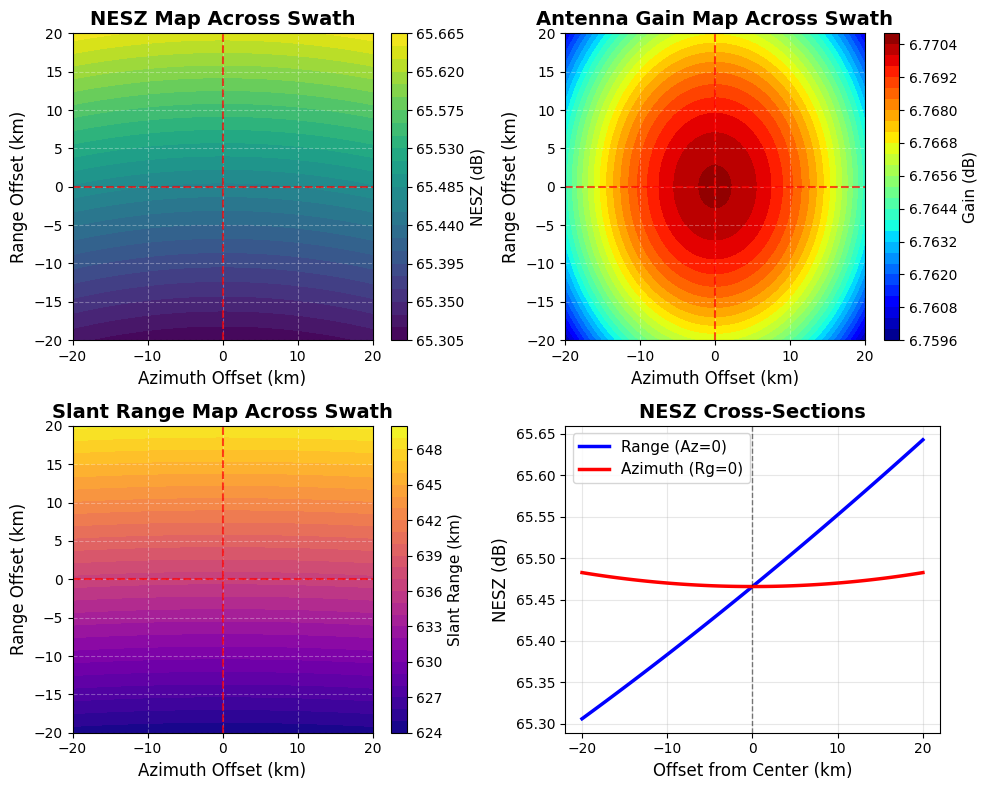

In [29]:
# Plot the comprehensive NESZ map
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Convert to km for plotting
range_km = range_offsets / 1e3
azimuth_km = azimuth_offsets / 1e3

# Plot 1: NESZ Map
ax1 = axes[0, 0]
contour1 = ax1.contourf(azimuth_km, range_km, nesz_map, levels=30, cmap='viridis')
ax1.set_xlabel('Azimuth Offset (km)', fontsize=12)
ax1.set_ylabel('Range Offset (km)', fontsize=12)
ax1.set_title('NESZ Map Across Swath', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, color='white', linestyle='--')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Center')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
cbar1 = fig.colorbar(contour1, ax=ax1)
cbar1.set_label('NESZ (dB)', fontsize=11)

# Plot 2: Antenna Gain Map
ax2 = axes[0, 1]
contour2 = ax2.contourf(azimuth_km, range_km, gain_map, levels=30, cmap='jet')
ax2.set_xlabel('Azimuth Offset (km)', fontsize=12)
ax2.set_ylabel('Range Offset (km)', fontsize=12)
ax2.set_title('Antenna Gain Map Across Swath', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, color='white', linestyle='--')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
cbar2 = fig.colorbar(contour2, ax=ax2)
cbar2.set_label('Gain (dB)', fontsize=11)

# Plot 3: Slant Range Map
ax3 = axes[1, 0]
contour3 = ax3.contourf(azimuth_km, range_km, slant_range_map/1e3, levels=30, cmap='plasma')
ax3.set_xlabel('Azimuth Offset (km)', fontsize=12)
ax3.set_ylabel('Range Offset (km)', fontsize=12)
ax3.set_title('Slant Range Map Across Swath', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, color='white', linestyle='--')
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
cbar3 = fig.colorbar(contour3, ax=ax3)
cbar3.set_label('Slant Range (km)', fontsize=11)

# Plot 4: Cross-sections
ax4 = axes[1, 1]
# Range cross-section (through center, azimuth=0)
center_azimuth_idx = n_azimuth // 2
ax4.plot(range_km, nesz_map[:, center_azimuth_idx], 'b-', linewidth=2.5, label='Range (Az=0)')
# Azimuth cross-section (through center, range=0)
center_range_idx = n_range // 2
ax4.plot(azimuth_km, nesz_map[center_range_idx, :], 'r-', linewidth=2.5, label='Azimuth (Rg=0)')
ax4.set_xlabel('Offset from Center (km)', fontsize=12)
ax4.set_ylabel('NESZ (dB)', fontsize=12)
ax4.set_title('NESZ Cross-Sections', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=11)
ax4.axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()